In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes

In [2]:
!nvidia-smi

Sun Dec 18 07:57:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tb
import h5py
import numpy as np
import pickle
import torchsummary

In [4]:
epochs=1000
learning_rate=0.001
batch_size=50

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
class MAMLASDataset(torch.utils.data.Dataset):
    import numpy as np
    def __init__(self,hdf5_file,root_dir="/",transform=None):
        super(MAMLASDataset, self).__init__()
        self.annotations=h5py.File(hdf5_file,"r")
        self.root_dir=root_dir
        self.data=torch.from_numpy(np.array(self.annotations[self.root_dir+"data"])).to(dtype=torch.float32).unsqueeze_(1)
        self.label_X=torch.from_numpy(np.array(self.annotations[self.root_dir+"label_X"])).to(dtype=torch.float32)
        self.label_T=torch.from_numpy(np.array(self.annotations[self.root_dir+"label_T"])).to(dtype=torch.float32)
        self.T_min=torch.from_numpy(np.array(self.annotations[self.root_dir+"T_min"])).to(dtype=torch.float32)
        self.T_max=torch.from_numpy(np.array(self.annotations[self.root_dir+"T_max"])).to(dtype=torch.float32)
        self.X_min=torch.from_numpy(np.array(self.annotations[self.root_dir+"X_min"])).to(dtype=torch.float32)
        self.X_max=torch.from_numpy(np.array(self.annotations[self.root_dir+"X_max"])).to(dtype=torch.float32)        
        self.transform=transform
        

    def __len__(self):
        return (self.data.shape[0])
    
    def __getitem__(self, index):
        assert index in range(self.data.shape[0]),"Dataset index out of bounds"
        data=self.data[index]
        if self.transform is not None:
            data=self.transform(data)

       
        return (data,torch.stack((self.label_T[index],self.label_X[index]),0))

In [7]:
dataset=MAMLASDataset(hdf5_file="./drive/MyDrive/MAMLAS_data/MAMLAS_TRAINDATA_SELECTED_8_TOMO_10000_NONUNI_X.hdf5",root_dir="/",transform=None)
train_ds,test_ds=torch.utils.data.random_split(dataset,[9500,500])
train_dl=torch.utils.data.DataLoader(train_ds,batch_size, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=True)

In [6]:
data=next(iter(train_dl))[0]
next(iter(train_dl))[1].shape

torch.Size([50, 2, 50, 50])

In [7]:
print(data.shape)
convd11=nn.ConvTranspose2d(1,8,(3,3),stride=(2,2),padding=(1,1),output_padding=(1,1))
a=convd11(data)
a.flatten().shape

torch.Size([50, 1, 100, 8])


torch.Size([1280000])

In [8]:

# class YNet(nn.Module):
#     def __init__(self,inputdim:tuple,outputdim:tuple):

#         super(YNet,self).__init__()

#         self.w,self.h=inputdim
#         self.ow,self.oh=outputdim

#         self.D1_inputchannels=1
#         self.D1_outputchannels=64
#         self.D2_inputchannels=2*self.D1_outputchannels
#         self.D2_outputchannels=self.D2_inputchannels
#         self.Bridge_inputchannels=2*self.D2_outputchannels
#         self.Bridge_outputchannels=256
#         self.TB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
#         self.TB1_outputchannels=self.Bridge_outputchannels//4
#         self.TB2_inputchannels=self.TB1_outputchannels+self.D2_inputchannels
#         self.TB2_outputchannels=self.TB1_outputchannels
#         self.XB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
#         self.XB1_outputchannels=self.Bridge_outputchannels//4
#         self.XB2_outputchannels=self.XB1_outputchannels

#         self.D11=nn.Sequential(
#             nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D1_outputchannels),
#             nn.ReLU()
#         )

#         self.D12=nn.Sequential(
#             nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D1_outputchannels),
#             nn.ReLU(),
#             nn.Conv2d(self.D1_outputchannels,self.D1_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D1_outputchannels),
#             nn.ReLU()
#         )

#         self.D21=nn.Sequential(
#             nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D2_outputchannels),
#             nn.ReLU()
#         )

#         self.D22=nn.Sequential(
#             nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D2_outputchannels),
#             nn.ReLU(),
#             nn.Conv2d(self.D2_outputchannels,self.D2_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.D2_outputchannels),
#             nn.ReLU()
#         )

#         self.Bridge=nn.Sequential(
#             nn.Conv2d(self.Bridge_inputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.Bridge_outputchannels),
#             nn.ReLU(),
#             nn.Conv2d(self.Bridge_outputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
#             nn.BatchNorm2d(self.Bridge_outputchannels),
#             nn.ReLU()
#         )

#         self.T=nn.Linear(self.TB2_outputchannels*self.w*self.h,self.ow*self.oh)

#         self.TB1=nn.Sequential(
#             nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(self.TB1_outputchannels),
#             nn.ReLU()
#         )

#         # self.TB1_conv=nn.Sequential(
#         #     nn.Conv2d(self.TB1_conv_inputchannels,self.TB1_conv_outputchannels,(3,3),padding='same'),
#         #     nn.BatchNorm2d(self.TB1_conv_outputchannels),
#         #     nn.ReLU(),
#         # )  

#         self.TB2=nn.Sequential(
#             nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(self.TB2_outputchannels),
#             nn.ReLU()
#         )

#         # self.TB2_conv=nn.Sequential(
#         #     nn.Conv2d(self.TB2_conv_inputchannels,self.TB2_conv_outputchannels,(3,3),padding='same'),
#         #     nn.BatchNorm2d(self.TB2_conv_outputchannels),
#         #     nn.ReLU(),
#         # )  

#         self.X=nn.Linear(self.XB2_outputchannels*self.w*self.h,self.ow*self.oh)

#         self.XB1=nn.Sequential(
#             nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(self.TB1_outputchannels),
#             nn.ReLU()
#         )

#         self.XB2=nn.Sequential(
#             nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
#             nn.BatchNorm2d(self.TB2_outputchannels),
#             nn.ReLU()
#         )


#     def forward(self,x):
#         out11=self.D11(x)
#         out12=self.D12(x)
#         out1=functional.max_pool2d(torch.concat((out11,out12),1),2)
#         out21=self.D21(out1)
#         out22=self.D22(out1)
#         out2=functional.max_pool2d(torch.concat((out21,out22),1),2)
#         out_bridge=self.Bridge(out2)
        
#         out_t1=self.TB1(out_bridge)
#         out_x1=self.XB1(out_bridge)

#         out_t2=self.TB1_conv(torch.concat(out_2,out_t1))
#         out_x2=self.XB1_conv(torch.concat(out_2,out_x1)) 


#         out_t1=self.TB1(torch.concat((out2,out_bridge),1))
#         out_t2=self.TB2(torch.concat((out1,out_t1),1))
#         out_T=torch.reshape(self.T(out_t2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])

#         out_x1=self.XB1(torch.concat((out2,out_bridge),1))
#         out_x2=self.XB2(torch.concat((out1,out_x1),1))
#         out_X=torch.reshape(self.X(out_x2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])


#         return torch.stack((out_T,out_X),dim=1)
    
#model=YNet((100,8),(50,50)).to(device)


class YNet(nn.Module):
    def __init__(self,inputdim:tuple,outputdim:tuple):

        super(YNet,self).__init__()

        self.w,self.h=inputdim
        self.ow,self.oh=outputdim

        self.D1_inputchannels=1
        self.D1_outputchannels=64
        self.D2_inputchannels=2*self.D1_outputchannels
        self.D2_outputchannels=self.D2_inputchannels
        self.Bridge_inputchannels=2*self.D2_outputchannels
        self.Bridge_outputchannels=256
        self.TB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
        self.TB1_outputchannels=self.Bridge_outputchannels//4
        self.TB2_inputchannels=self.TB1_outputchannels+self.D2_inputchannels
        self.TB2_outputchannels=self.TB1_outputchannels
        self.XB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
        self.XB1_outputchannels=self.Bridge_outputchannels//4
        self.XB2_outputchannels=self.XB1_outputchannels

        self.D11=nn.Sequential(
            nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU()
        )

        self.D12=nn.Sequential(
            nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.D1_outputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU()
        )

        self.D21=nn.Sequential(
            nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU()
        )

        self.D22=nn.Sequential(
            nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.D2_outputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU()
        )

        self.Bridge=nn.Sequential(
            nn.Conv2d(self.Bridge_inputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.Bridge_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.Bridge_outputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.Bridge_outputchannels),
            nn.ReLU()
        )

        self.T=nn.Linear(self.TB2_outputchannels*self.w*self.h,self.ow*self.oh)

        self.TB1=nn.Sequential(
            nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB1_outputchannels),
            nn.ReLU()
        )

        self.TB2=nn.Sequential(
            nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB2_outputchannels),
            nn.ReLU()
        )

        self.X=nn.Linear(self.XB2_outputchannels*self.w*self.h,self.ow*self.oh)

        self.XB1=nn.Sequential(
            nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB1_outputchannels),
            nn.ReLU()
        )

        self.XB2=nn.Sequential(
            nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB2_outputchannels),
            nn.ReLU()
        )


    def forward(self,x):
        out11=self.D11(x)
        out12=self.D12(x)
        out1=functional.max_pool2d(torch.concat((out11,out12),1),2)
        out21=self.D21(out1)
        out22=self.D22(out1)
        out2=functional.max_pool2d(torch.concat((out21,out22),1),2)
        out_bridge=self.Bridge(out2)

        out_t1=self.TB1(torch.concat((out2,out_bridge),1))
        out_t2=self.TB2(torch.concat((out1,out_t1),1))
        out_T=torch.reshape(self.T(out_t2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])

        out_x1=self.XB1(torch.concat((out2,out_bridge),1))
        out_x2=self.XB2(torch.concat((out1,out_x1),1))
        out_X=torch.reshape(self.X(out_x2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])


        return torch.stack((out_T,out_X),dim=1)
        

In [11]:
f=open("/content/drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth.bak",'rb')
model=pickle.load(f)
f.close()

In [12]:
sum(p.numel() for p in model.parameters())

261800136

In [13]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

261800136

In [14]:
train_loss = list()
validation_loss = list()

In [15]:
criterion = nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.0000005, weight_decay=0.03)

In [16]:
model.train()
for epoch in range(epochs):
    loss=0
    for data,target in train_dl:
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        predict=model(data)
        loss=criterion(predict,target)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch+1} / {epochs} , train_loss {loss.item():.4f}")
    train_loss.append(loss.item())
    if(loss <= min(train_loss)):
        with open("./drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth", "wb") as f:
            pickle.dump(model, f)
        print(
            f" [best model]: epoch {epoch+1} / {epochs} , train_loss {loss.item():.4f}") 
        with open("./best_model_tomography_selected_8_tomo_10000_nonuni_x.pth", "wb") as f:
            pickle.dump(model, f)   
    with torch.no_grad():
        loss = 0
        for data, target in test_dl:
            data = data.to(device)
            target = target.to(device)
            model.eval()
            predict = model(data)
            model.train()
            loss += torch.max(torch.abs(predict-target))
        print(f"epoch {epoch+1} / {epochs} , validation_loss {loss.item():.4f}")
        validation_loss.append(loss.item())        

epoch 1 / 1000 , train_loss 88.5737
 [best model]: epoch 1 / 1000 , train_loss 88.5737
epoch 1 / 1000 , validation_loss 2.6095
epoch 2 / 1000 , train_loss 60.8277
 [best model]: epoch 2 / 1000 , train_loss 60.8277
epoch 2 / 1000 , validation_loss 2.0284
epoch 3 / 1000 , train_loss 70.1649
epoch 3 / 1000 , validation_loss 1.6630
epoch 4 / 1000 , train_loss 32.4329
 [best model]: epoch 4 / 1000 , train_loss 32.4329
epoch 4 / 1000 , validation_loss 1.3953
epoch 5 / 1000 , train_loss 24.4314
 [best model]: epoch 5 / 1000 , train_loss 24.4314
epoch 5 / 1000 , validation_loss 1.3749
epoch 6 / 1000 , train_loss 24.6211
epoch 6 / 1000 , validation_loss 1.1763


KeyboardInterrupt: ignored

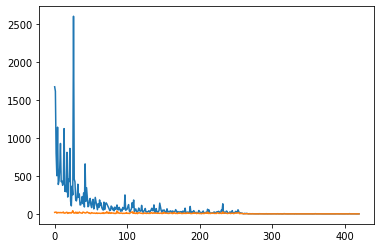

In [ ]:
plt.plot(train_loss)
plt.plot(validation_loss)

Average error in T: 0.410865283203125
Maximum error in T: 1.200457763671875
Minimum error in T: 0.08662565231323242
Average error in X: 0.736837890625
Maximum error in X: 2.1029902648925782
Minimum error in X: 0.18280628204345703


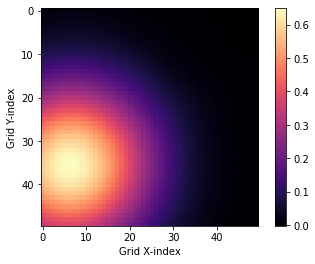

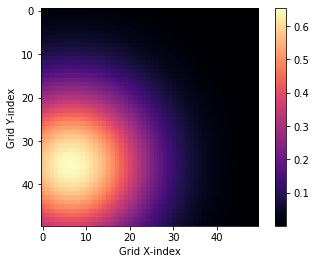

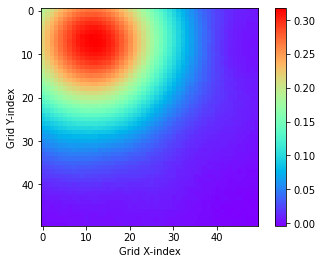

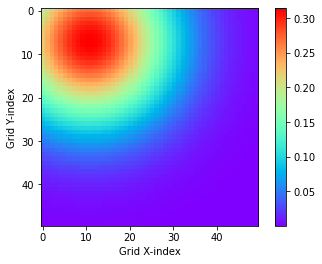

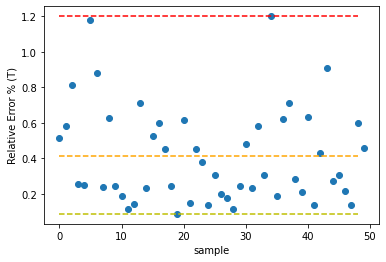

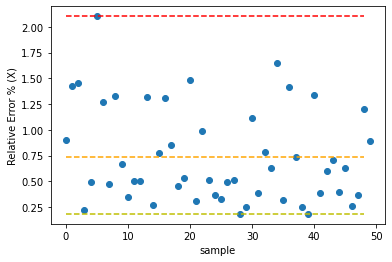

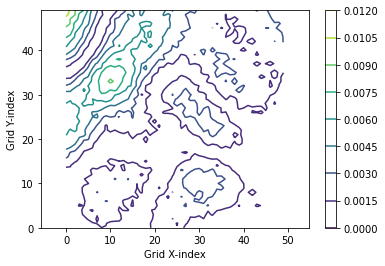

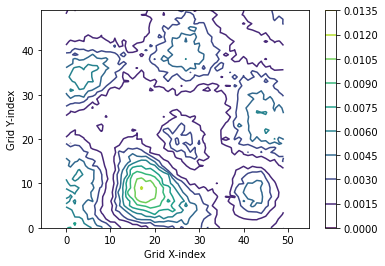

In [22]:
from random import randint
from numpy import linspace, meshgrid


x,y=meshgrid(linspace(0,1,10),linspace(0,1,10))
f=open("/content/drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x_cpu.pth.bakcpu",'rb')
model_test=pickle.load(f)
model_test=model_test.to('cpu')
f.close()
model_test.eval()
with torch.no_grad():
    data,target=next(iter(test_dl))#[randint(0,len(test_dl))]
    predict=model_test(data)
    index=randint(0,49)
    fig=plt.figure(0)
    plt.imshow(np.array(predict[index][0]),cmap="magma")
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.colorbar()
    fig=plt.figure(1)
    plt.imshow(np.array(target[index][0]),cmap="magma")
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.colorbar()
    fig=plt.figure(2)
    plt.imshow(np.array(predict[index][1]),cmap="rainbow")
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.colorbar()
    fig=plt.figure(3)
    plt.imshow(np.array(target[index][1]),cmap="rainbow")
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.colorbar()

    errT=list()
    errX=list()
    for i in range(0,50):
        errT.append(np.sum(np.abs(np.array(predict[i][0])-np.array(target[i][0]))))
        errX.append(np.sum(np.abs(np.array(predict[i][1])-np.array(target[i][1]))))
    
    print("Average error in T: "+str(np.sum(errT)/1250))
    print("Maximum error in T: "+str(np.max(errT)/25))
    print("Minimum error in T: "+str(np.min(errT)/25))
    print("Average error in X: "+str(np.sum(errX)/1250))
    print("Maximum error in X: "+str(np.max(errX)/25))
    print("Minimum error in X: "+str(np.min(errX)/25))

    plt.figure(4)
    plt.plot(np.array(errT)/25,'o',linestyle='None')
    plt.xlabel('sample')
    plt.ylabel('Relative Error % (T)')
    plt.plot(np.sum(errT)/1250*np.ones((49,1)),'--',c='orange')
    plt.plot(max(errT)/25*np.ones((49,1)),'r--')
    plt.plot(min(errT)/25*np.ones((49,1)),'y--')

    plt.figure(5)
    plt.plot(np.array(errX)/25,'o',linestyle='None')
    plt.xlabel('sample')
    plt.ylabel('Relative Error % (X)')
    plt.plot(np.sum(errX)/1250*np.ones((49,1)),'--',c='orange')
    plt.plot(max(errX)/25*np.ones((49,1)),'r--')
    plt.plot(min(errX)/25*np.ones((49,1)),'y--')

    plt.figure(6)
    plt.contour(np.abs(np.array(predict[index][0]-target[index][0])),levels=10)
    plt.xlim((0,49))
    plt.ylim((0,49))
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.axis('equal')
    plt.colorbar()

    plt.figure(7)
    plt.contour(np.abs(np.array(predict[index][1]-target[index][1])),levels=10)
    plt.xlim((0,49))
    plt.ylim((0,49))
    plt.xlabel('Grid X-index')
    plt.ylabel('Grid Y-index')
    plt.axis('equal')
    plt.colorbar()
    


    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(predict[index][0])-np.array(target[index][0]))
    # plt.show()
    # fig=plt.figure(1)
    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(target[index][0]))
    # plt.show()

In [ ]:
# import shutil
# colab_link = "/content/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth"
# gdrive_link = "/content/drive/MyDrive/MAMLAS_data/"
# shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth'

In [ ]:
model_test.eval()
with torch.no_grad():
    data,target=next(iter(test_dl))#[randint(0,len(test_dl))]
    predict=model_test(data)

Average error in T: 34.523053125
Maximum error in T: 59.54998046875
Minimum error in T: 7.74820556640625
Average error in X: 26.249746875
Maximum error in X: 54.118994140625
Minimum error in X: 3.9829327392578127


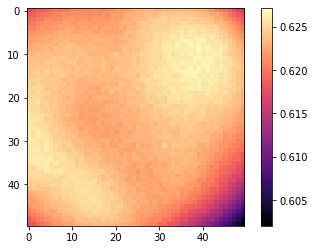

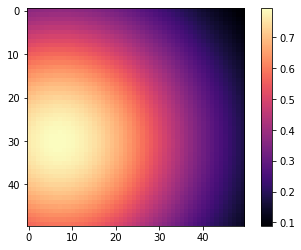

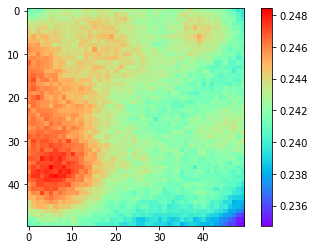

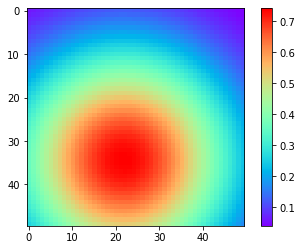

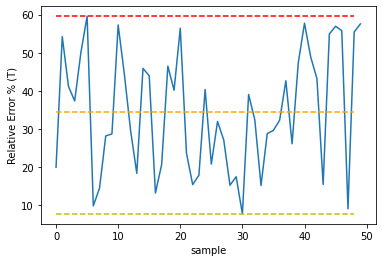

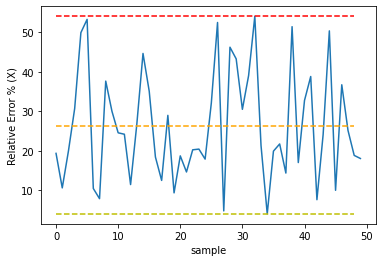

In [ ]:
from random import randint
from numpy import linspace, meshgrid


x,y=meshgrid(linspace(0,1,10),linspace(0,1,10))
f=open("/content/drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth.bak2",'rb')
model_test=pickle.load(f)
model_test=model_test.to('cpu')
f.close()
model_test.eval()
with torch.no_grad():
    data,target=next(iter(test_dl))#[randint(0,len(test_dl))]
    data=data[0][0][0]
    data=data.repeat(50,1,100,1)
    predict=model_test(data)




    index=randint(0,49)
    fig=plt.figure(0)
    plt.imshow(np.array(predict[index][0]),cmap="magma")
    plt.colorbar()
    fig=plt.figure(1)
    plt.imshow(np.array(target[index][0]),cmap="magma")
    plt.colorbar()
    fig=plt.figure(2)
    plt.imshow(np.array(predict[index][1]),cmap="rainbow")
    plt.colorbar()
    fig=plt.figure(3)
    plt.imshow(np.array(target[index][1]),cmap="rainbow")
    plt.colorbar()

    errT=list()
    errX=list()
    for i in range(0,50):
        errT.append(np.sum(np.abs(np.array(predict[i][0])-np.array(target[i][0]))))
        errX.append(np.sum(np.abs(np.array(predict[i][1])-np.array(target[i][1]))))
    
    print("Average error in T: "+str(np.sum(errT)/1250))
    print("Maximum error in T: "+str(np.max(errT)/25))
    print("Minimum error in T: "+str(np.min(errT)/25))
    print("Average error in X: "+str(np.sum(errX)/1250))
    print("Maximum error in X: "+str(np.max(errX)/25))
    print("Minimum error in X: "+str(np.min(errX)/25))

    plt.figure(4)
    plt.plot(np.array(errT)/25)
    plt.xlabel('sample')
    plt.ylabel('Relative Error % (T)')
    plt.plot(np.sum(errT)/1250*np.ones((49,1)),'--',c='orange')
    plt.plot(max(errT)/25*np.ones((49,1)),'r--')
    plt.plot(min(errT)/25*np.ones((49,1)),'y--')

    plt.figure(5)
    plt.plot(np.array(errX)/25)
    plt.xlabel('sample')
    plt.ylabel('Relative Error % (X)')
    plt.plot(np.sum(errX)/1250*np.ones((49,1)),'--',c='orange')
    plt.plot(max(errX)/25*np.ones((49,1)),'r--')
    plt.plot(min(errX)/25*np.ones((49,1)),'y--')

    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(predict[index][0])-np.array(target[index][0]))
    # plt.show()
    # fig=plt.figure(1)
    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(target[index][0]))
    # plt.show()

In [ ]:
data_test=data[0][0][0]

In [ ]:
data_test=data_test.repeat(50,1,100,1)

In [ ]:
data_test[0][0][0]==data_test[2][0][5]

tensor([True, True, True, True, True, True, True, True])

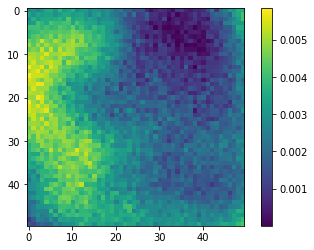

In [ ]:
plt.figure(6)
plt.imshow(np.abs(np.array(predict[index][0]-target[index][0])))
plt.colorbar()

In [ ]:
np.abs(np.array(predict[index][0]-target[index][0])).shape

(50, 50)